In [53]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
import os
import json
from random import sample
from scipy.ndimage import zoom
#from soma import aims
#import dico_toolbox as dtb
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [77]:
# take val data from both folds, being in two separate models
# because training is done in classifier mode which requires a manual Cross Validation by running the model twice inverting train and val. Here cv=2.
""""
dir_models = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/'
models = ['/gradCAM/fold1/', '/gradCAM/fold2/']
results = ['STs_dHCP_374_supervised_results','STs_dHCP_374_supervised_results']
pred = 'val_predictions.csv'

val_y = 'val_y'
val_pred = 'val_pred'
"""
dir_models = '/neurospin/dico/jlaval/Runs/02_STS_babies/Program/Output/'
models = ['linear_classification/ukb_1_fold1', 'linear_classification/ukb_1_fold2']
results = ['dHCP_fold1_supervised_results', 'dHCP_fold2_supervised_results']
pred = 'outputs/val_probas.csv'

val_y = 'labels'
val_pred = 'dim2'

# be careful to run each supervised_pipeline.py with the right train / val config. need to change the config for both runs...
# val must be val and not train if inverted for training ..

gradients_dict_list = []
for model, result in zip(models, results):
    with open(f'{dir_models}/{model}/{result}/attributions.pkl', 'rb') as f:
        gradients_dict = pickle.load(f)
    gradients_dict = gradients_dict['val']
    print(gradients_dict['0'].keys())
    gradients_dict_list.append(gradients_dict)

gradients_dict = {'0': {},
                '1': {}}
for target in gradients_dict.keys():
    gradients_dict[target] = {subject: grad
                    for gradients_d in gradients_dict_list
                    for subject, grad in gradients_d[target].items()}

dict_keys(['CC00065XX08', 'CC00067XX10', 'CC00068XX11', 'CC00071XX06', 'CC00073XX08', 'CC00074XX09', 'CC00075XX10', 'CC00080XX07', 'CC00082XX09', 'CC00086XX13', 'CC00088XX15', 'CC00091XX10', 'CC00096XX15', 'CC00100XX01', 'CC00101XX02', 'CC00102XX03', 'CC00105XX06', 'CC00111XX04', 'CC00113XX06', 'CC00114XX07', 'CC00115XX08', 'CC00116XX09', 'CC00117XX10', 'CC00119XX12', 'CC00122XX07', 'CC00126XX11', 'CC00127XX12', 'CC00130XX07', 'CC00131XX08', 'CC00134XX11', 'CC00138XX15', 'CC00139XX16', 'CC00143BN12', 'CC00144XX13', 'CC00145XX14', 'CC00149XX18', 'CC00150AN02', 'CC00153XX05', 'CC00155XX07', 'CC00159XX11', 'CC00160XX04', 'CC00162XX06', 'CC00163XX07', 'CC00164XX08', 'CC00165XX09', 'CC00168XX12', 'CC00171XX07', 'CC00174XX10', 'CC00178XX14', 'CC00179XX15', 'CC00180XX08', 'CC00182XX10', 'CC00183XX11', 'CC00184XX12', 'CC00185XX13', 'CC00189XX17', 'CC00198XX18', 'CC00199XX19', 'CC00200XX02', 'CC00201XX03', 'CC00202XX04', 'CC00203XX05', 'CC00204XX06', 'CC00205XX07', 'CC00206XX08', 'CC00207XX09',

In [78]:
subjects = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton_subject.csv')
subjects = subjects['Subject'].tolist()

In [79]:
skels = np.load("/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rskeleton.npy")
print(skels.shape)

(374, 22, 49, 46, 1)


In [80]:
# after Anatomist loads, run this
%matplotlib inline

######################
# TEST
######################
idx = 100
plane = 0
step = 2
classes = ['0', '1'] # binary classif : need only one value ?
######################

skel= skels[idx]
skel = skel != 0
subject = subjects[idx]

plt.close()

cmap = mpl.cm.get_cmap("OrRd").copy()
cmap.set_bad(color='black')

for c in classes: 
    gradient = gradients_dict['train'][c][subject]
    resize_ratio = np.array(skel.shape) / np.array(gradient.shape)
    # interpolate gradient to skel dimensions, would be better to perform computation before plot
    # AXES SHOULD BE REORDERED ?
    gradient = zoom(gradient,
                    resize_ratio,
                    order=3)
    gradient_intersect = np.ma.masked_where(skel == 0, gradient)
    idxs = [*range(8, gradient.shape[plane], step)]

    fig, axs = plt.subplots(ncols=len(idxs), figsize=(6*len(idxs), 6))
    for idx, x in enumerate(idxs):
        if plane == 0:
            axs[idx].imshow(gradient_intersect[x,:,:,0], cmap=cmap)
        elif plane == 1:
            axs[idx].imshow(gradient_intersect[:,x,:,0], cmap=cmap)
        elif plane == 2:
            axs[idx].imshow(gradient_intersect[:,:,x,0], cmap=cmap)
        axs[idx].set_title(f'ax value = {x}')
    plt.suptitle(f'gradCAM for class {c}')

In [82]:
# visualize average gradient in both TP FP TN FN : but need a classif threshold ?
# 0 = fullterm
# 1 = preterm
# but inverted in predictions ? Closer to 1 = fullterm
predictions_list = []
for model, result in zip(models, results):
    predictions = pd.read_csv(f'{dir_models}/{model}/{result}/{pred}')
    predictions_list.append(predictions)
predictions = pd.concat(predictions_list)

# first find good threshold
# optimize balanced accuracy
thresholds = np.linspace(0,1,1000)
#accuracies = [balanced_accuracy_score(predictions['val y'], predictions['val pred'] > threshold) for threshold in thresholds]
#print(f'best balanced accuracy: {max(accuracies)} \nbest threshold: {thresholds[np.argmax(accuracies)]}]')
# predictions using this threshold
#preds = (predictions['val pred'] > thresholds[np.argmax(accuracies)])


## is it dim1 or dim2 ???
accuracies = [balanced_accuracy_score(predictions[val_y], predictions[val_pred] > threshold) for threshold in thresholds]
print(f'best balanced accuracy: {max(accuracies)} \nbest threshold: {thresholds[np.argmax(accuracies)]}]')
# predictions using this threshold
preds = (predictions[val_pred] > thresholds[np.argmax(accuracies)])

best balanced accuracy: 0.8238647159414783 
best threshold: 0.36436436436436437]


In [83]:
predictions.shape

(296, 4)

In [85]:
predictions[predictions[val_y]==True]

,ID,labels,dim1,dim2
139,CC00518XX15,1,0.096060,0.903940
140,CC00526XX15,1,0.120470,0.879530
141,CC00529AN18,1,0.478646,0.521354
142,CC00529BN18,1,0.197206,0.802794
143,CC00530XX11,1,0.179552,0.820448
144,CC00618XX16,1,0.109565,0.890435
145,CC00629XX19,1,0.631855,0.368145
146,CC00661XX10,1,0.302036,0.697964
147,CC00666XX15,1,0.278816,0.721184
81,CC00694XX19,1,0.809142,0.190858


In [86]:
conf_matrix = confusion_matrix(predictions[val_y], preds)
print(f'TN = {conf_matrix[0, 0]}\nFP = {conf_matrix[0, 1]}\nFN = {conf_matrix[1, 0]}\nTP = {conf_matrix[1, 1]}')

TN = 194
FP = 83
FN = 1
TP = 18


In [87]:
# check average age of each group

# Release3 dHCP : select subjects from info dataframe

dir_Release3 = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_Release3) as f:
    subjects_R3 = json.load(f)

subjects_R3 = list(subjects_R3.keys())

# get the session ids of R3
dir_sessions = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/denis/release3_scripts/subjects_file_v4.json'
with open(dir_sessions) as f:
    dict_sessions = json.load(f)
sessions = [value['session_id'] for _, value in dict_sessions.items()]

# get dHCP info
dir_info_dHCP = '/home/jl274628/Documents/info_dHCP.tsv'
info_dHCP = pd.read_csv(dir_info_dHCP, usecols=['participant_id', 'birth_age', 'scan_age', 'session_id'], sep='\t')
# filter over subjects
info_dHCP.drop(info_dHCP[~(info_dHCP['participant_id'].isin(subjects_R3))].index, inplace = True)
#info_dHCP.drop(info_dHCP[(info_dHCP['scan_number']!=1)].index, inplace = True) # not always scan 1
# filter over sessions
info_dHCP.drop(info_dHCP[~(info_dHCP['session_id'].isin(sessions))].index, inplace = True)
info_dHCP.reset_index(drop=True, inplace=True)

In [88]:
# AUC after gathering the preds from folds

roc_auc_score(predictions[val_y], predictions[val_pred])

0.8479954398631959

In [94]:
scores

,ID,labels,dim1,dim2
0,CC00065XX08,0,0.939669,0.060331
1,CC00067XX10,0,0.801613,0.198387
2,CC00068XX11,0,0.597457,0.402543
3,CC00071XX06,0,0.079389,0.920611
4,CC00073XX08,0,0.949660,0.050340
...,...,...,...,...
143,CC01192XX14,0,0.979939,0.020061
144,CC01194XX16,0,0.843519,0.156481
145,CC01198XX20,0,0.355903,0.644097
146,CC01199XX21,0,0.898982,0.101018


In [95]:
# print classification score of each subject
# check consistency between birth_age and train_y
scores = predictions.copy()
scores = predictions[['ID', 'labels', 'dim2']] # comment in the first setting
scores.columns = ['participant_id', val_y, val_pred]
df = pd.merge(info_dHCP, scores)
df.loc[df[val_y]==1]

,participant_id,session_id,birth_age,scan_age,labels,dim2
165,CC00518XX15,166600,26.142857,42.86,1,0.903940
167,CC00526XX15,169900,26.142857,41.71,1,0.879530
170,CC00529AN18,170000,27.428571,42.29,1,0.521354
171,CC00529BN18,170100,27.428571,42.29,1,0.802794
172,CC00530XX11,181301,26.142857,42.43,1,0.820448
211,CC00618XX16,193600,27.428571,40.14,1,0.890435
214,CC00629XX19,198100,24.714286,41.14,1,0.368145
220,CC00661XX10,209600,27.571429,39.00,1,0.697964
222,CC00666XX15,212100,23.714286,38.57,1,0.721184
229,CC00694XX19,228100,24.428571,44.00,1,0.190858


In [96]:
# make groups of subjects for gradient averaging
names = df['participant_id']
preds = (df[val_pred] > thresholds[np.argmax(accuracies)])
TN_subjects = np.array(names)[np.where((np.array(df[val_y])==0) & (preds==0))[0]]
FP_subjects = np.array(names)[np.where((np.array(df[val_y])==0) & (preds==1))[0]]
FN_subjects = np.array(names)[np.where((np.array(df[val_y])==1) & (preds==0))[0]]
TP_subjects = np.array(names)[np.where((np.array(df[val_y])==1) & (preds==1))[0]]

In [97]:
dict_subjects_classes = {'TN': TN_subjects,
                         'FP': FP_subjects,
                         'FN': FN_subjects,
                         'TP': TP_subjects}

average age is not so different between well and wrongly classified. Overfit on the specific age, very different from regresser !

# Plot gradients

In [110]:
# select subset of subjects for classes TN and TP
subset = 18
random=False # if false, take top predictions

dict_subset_subjects_classes = {}
if random:
    for key, value in dict_subjects_classes.items():
        val = sample(list(value), min(subset, len(value)))
        dict_subset_subjects_classes[key]=val
else: # only for TN and TP...
    scores_sorted = scores.copy()
    scores_sorted = scores_sorted.sort_values(val_pred)
    scores_sorted_TN = scores_sorted.loc[scores_sorted['participant_id'].isin(dict_subjects_classes['TN'])]
    scores_sorted_TP = scores_sorted.loc[scores_sorted['participant_id'].isin(dict_subjects_classes['TP'])]
    dict_subset_subjects_classes['TN'] = scores_sorted_TN['participant_id'].to_numpy()[:subset]
    dict_subset_subjects_classes['TP'] = scores_sorted_TP['participant_id'].to_numpy()[-subset:]

In [111]:
sub_df = info_dHCP.loc[info_dHCP['birth_age']>37]
sub_df = sub_df.sample(subset)
l = sub_df['participant_id'].tolist()
l

['CC00613XX11',
 'CC00292XX13',
 'CC00067XX10',
 'CC00542XX15',
 'CC00484XX15',
 'CC00500XX05',
 'CC00114XX07',
 'CC00846XX22',
 'CC00183XX11',
 'CC00201XX03',
 'CC00801XX09',
 'CC00512XX09',
 'CC00948XX25',
 'CC00065XX08',
 'CC00071XX06',
 'CC00538XX19',
 'CC00568XX16',
 'CC00647XX21']

In [122]:
# use 0 or 1 for positive and negative classes
target = 0
gradients = gradients_dict[str(target)]

In [139]:
dict_average_gradients_classes = {}
keys = ['TN', 'TP']
targets = ['0', '1']
for key, target in zip(keys, targets):
    value = dict_subset_subjects_classes[key]
    dict_average_gradients_classes[key] = np.transpose(np.mean([gradient / np.mean(gradient) for (name, gradient) in gradients_dict[str(target)].items() if name in value], axis=0), (1,2,3,0))

# which smoothing used in gradcam upsampling ?
resize_ratio = np.array(skels[0].shape) / np.array(dict_average_gradients_classes['TN'].shape)
# interpolate gradient to skel dimensions
for key, value in dict_average_gradients_classes.items():
    value = zoom(value,
                resize_ratio,
                order=3)
    dict_average_gradients_classes[key] = value

In [140]:
for key in ['TN', 'TP']:
    print(f"mean gradient {key}: {np.mean(dict_average_gradients_classes[key])}")

mean gradient TN: 1.083814263343811
mean gradient TP: 1.0600546598434448


# 2D average gradient heatmap

In [141]:
# select the corresponding selected skels and average them
## WOULD NEED TO APPLY PHASING TO THE SKELS FIRST
threshold = 0.3
dict_average_skels_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_average_skels_classes[key] = np.mean([(skel!=0).astype(float) for i, skel in enumerate(skels) if subjects[i] in value], axis=0) > threshold

In [142]:
# define range for colormap normalization
mini = min([np.min(value) for key, value in dict_average_gradients_classes.items()])
maxi = max([np.max(value) for key, value in dict_average_gradients_classes.items()])
norm = plt.Normalize(mini, maxi)

In [143]:
# normalize each subject independently 
norms = {'TN': [],
         'TP': []}
for c in ['TN', 'TP']:
    arr = dict_average_gradients_classes[c]
    norms[c]=plt.Normalize(np.min(arr), np.max(arr))

Text(0.5, 0.98, 'Average gradients over plane 0')

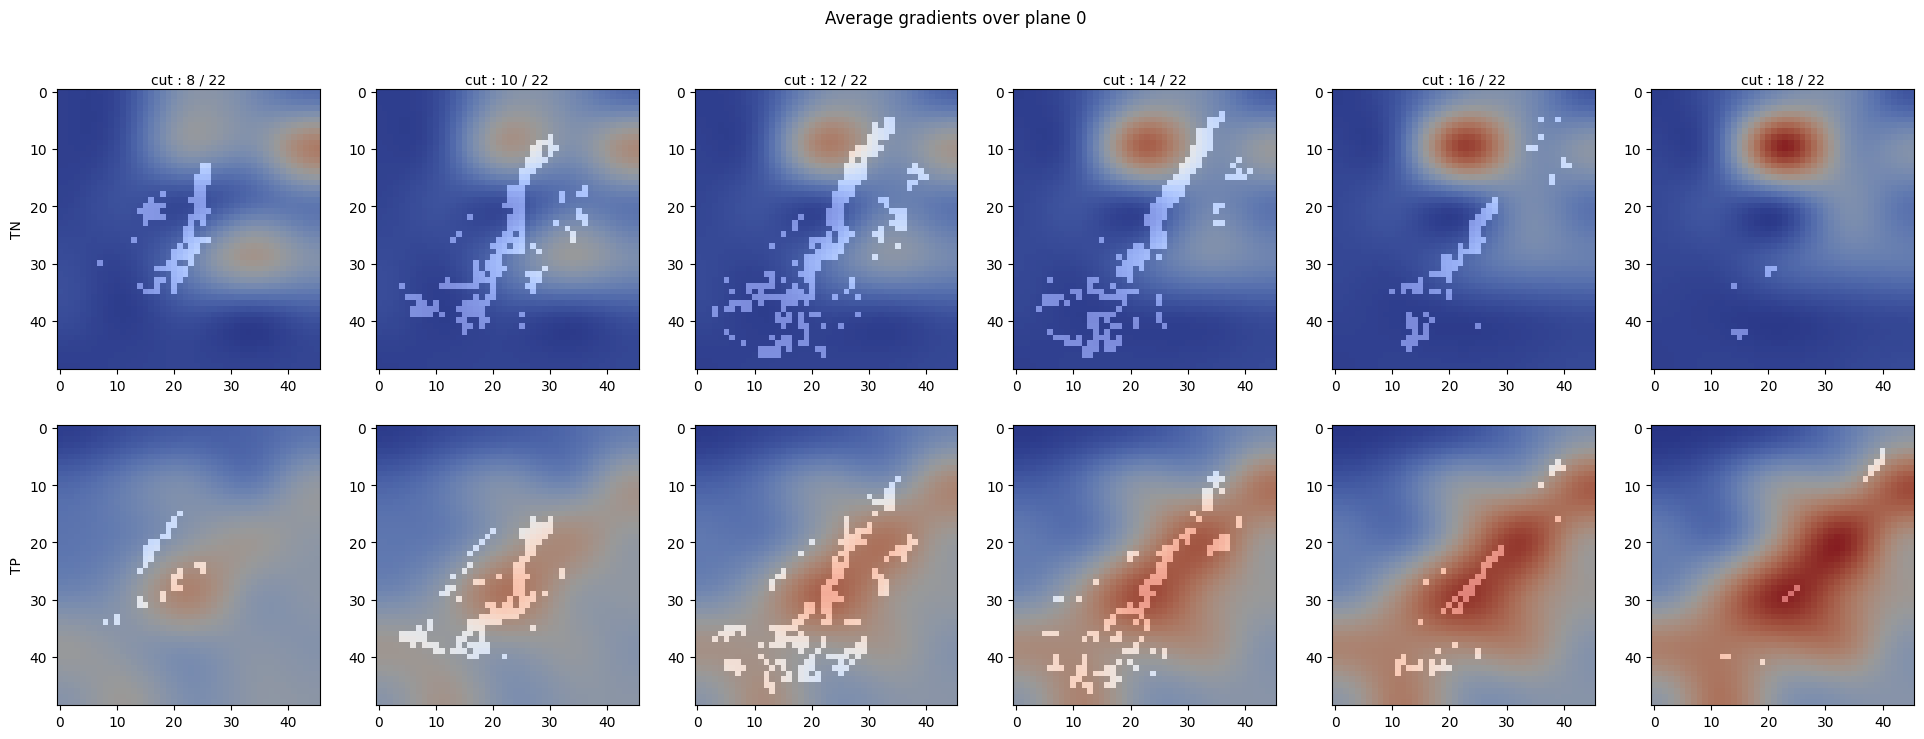

In [144]:
# UNIQUE TARGET HERE
###########################
plane = 0
step = 2
classes = ['TN', 'TP']
###########################
cut_borders=[8,3]

maxi_range = dict_average_gradients_classes['TN'].shape[plane]
idxs = [*range(0+cut_borders[0], maxi_range-cut_borders[1], step)]


fig, axs = plt.subplots(nrows=len(classes), ncols=len(idxs), figsize=(4*len(idxs),4*len(classes)))
for i, c in enumerate(classes):
    gradient = dict_average_gradients_classes[c]
    average_skel = dict_average_skels_classes[c]
    for j, x in enumerate(idxs):
        ax = axs[i, j]

        # select right plane
        if plane == 0:
            im = gradient[x,:,:,0]
            im_skel = average_skel[x,:,:,0]
        elif plane == 1:
            im = gradient[:,x,:,0]
            im_skel = average_skel[:,x,:,0]
        elif plane == 2:
            im = gradient[:,:,x,0]
            im_skel = average_skel[:,:,x,0]
        
        # show
        ax.imshow(im_skel, cmap='gray', alpha=1)
        ax.imshow(im, cmap='coolwarm', norm=norms[c], alpha=0.7)

# set labels on axes
for idx, c in enumerate(classes):
    ax = axs[idx, 0]
    ax.set_ylabel(c)
for idx, x in enumerate(idxs):
    ax = axs[0, idx]
    ax.set_xlabel(f'cut : {x} / {maxi_range}')
    ax.xaxis.set_label_position('top') 

plt.suptitle(f'Average gradients over plane {plane}')

In [145]:
for name in dict_subset_subjects_classes['TP']:
    val = df.loc[df['participant_id']==name][val_pred].tolist()[0]
    print(name, val)

CC00629XX19 0.36814538
CC00997BN25 0.39075857
CC00955XX15 0.49740204
CC00529AN18 0.5213542
CC01038XX16 0.56052756
CC00867XX18 0.60405594
CC00805XX13 0.61196506
CC00770XX12 0.6866465
CC00661XX10 0.6979642
CC00666XX15 0.7211836
CC00718XX17 0.7218135
CC00529BN18 0.8027939
CC01025XX11 0.8069547
CC00946XX23 0.819307
CC00530XX11 0.8204484
CC00526XX15 0.87953025
CC00618XX16 0.890435
CC00518XX15 0.9039401


Text(0.5, 0.98, 'Average gradients over sagittal plane')

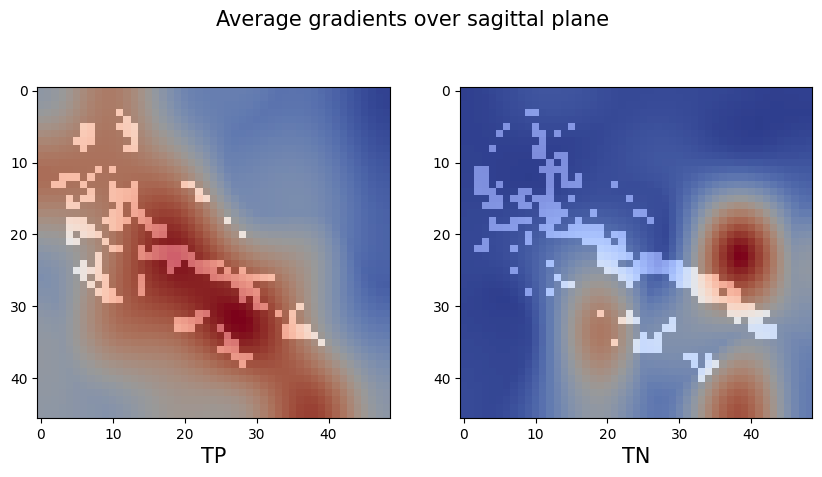

In [146]:
# let's replot in 2D according to plane 0, with single cut (middle) and max heatmap over plane
# UNIQUE TARGET HERE
###########################
plane = 0
classes = ['TP', 'TN']
###########################
x = 12


fig, axs = plt.subplots(ncols=len(classes), nrows=1, figsize=(5*len(classes), 5))
for i, c in enumerate(classes):
    ax=axs[i]
    gradient = dict_average_gradients_classes[c]
    average_skel = dict_average_skels_classes[c]

    # select right plane
    im = np.max(gradient[:,:,:,0], axis=plane)
    if plane == 0:
        im_skel = average_skel[x,:,:,0]
    elif plane == 1:
        im_skel = average_skel[:,x,:,0]
    elif plane == 2:
        im_skel = average_skel[:,:,x,0]
    
    # show
    im_skel = np.rot90(im_skel, axes=(1, 0))
    im = np.rot90(im, axes=(1, 0))
    ax.imshow(im_skel, cmap='gray', alpha=1)
    ax.imshow(im, cmap='coolwarm', norm=norms[c], alpha=0.7)
    ax.set_xlabel(c, fontsize=15)

plt.suptitle(f'Average gradients over sagittal plane', fontsize=15)
#plt.savefig(save_dir+'average_gradients.png', facecolor='white')

the average shows that it looks at the sulcus, but not much more: the overall gradient reaches a maximum at the level of the top ! (or bottom ? To confirm)

beware when mapping to 3D: (0,0) is at the top
NB: attention les cartes de gradients moyennes sont faites sans recalage, donc les moyennes sont diffuses et le sont d'autant plus quand la variabilité est forte. On risque de voir apparaître des diffférences entre TN et TP à cause de cela.
La carte de gradient paraît en dehors du squelette, mais cela est dû aux interpolations et au fait qu'on ne voit qu'un seul plan...

In [41]:
# individual skel dict
dict_skels_classes = {}
for key, value in dict_subset_subjects_classes.items():
    dict_skels_classes[key] = {subjects[i]: skel for i, skel in enumerate(skels) if subjects[i] in value}

In [42]:
# individual gradient dict
# NB: resize ratio defined previously

# target is opposit for each class
targets = ['0', '1']
dict_gradients_classes = {}
dict_subset_subjects_classes = {key: dict_subset_subjects_classes[key] for key in ['TN', 'TP']}
for target, (key, value) in zip(targets, dict_subset_subjects_classes.items()):
    print('target' + target + f' for class {key}')
    dict_gradients_classes[key] = {name: zoom(np.transpose(gradient,(1,2,3,0)), resize_ratio, order=3)  for name, gradient in gradients_dict[str(target)].items() if name in value}

target0 for class TN
target1 for class TP


In [43]:
# normalize each subject independently 

norms = {'TN': {},
         'TP': {}}
for c in ['TN', 'TP']:
    for subject, gradient in dict_gradients_classes[c].items():
        norm = plt.Normalize(np.min(gradient), np.max(gradient))
        norms[c][subject]=norm

# 2D individual gradient maps

In [169]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/gradCAM/'

###########################
plane = 0
# for x in range(11, 18, 1):
#plane = 1
#x = 14
#subset=17
classes = ['TN', 'TP']
###########################

cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad(color='black')


for x in range(0, 22, 1):
    plt.close()
    fig, axs = plt.subplots(nrows=len(classes), ncols=subset, figsize=(4*subset,4*len(classes)))
    for i, c in enumerate(classes):
        gradient_subjects = dict_gradients_classes[c]
        skel_subjects = dict_skels_classes[c]
        for j, name in enumerate(gradient_subjects.keys()):
            gradient, skel = gradient_subjects[name], skel_subjects[name]
            gradient_intersect = np.ma.masked_where(skel == 0, gradient)

            ax = axs[i, j]
            # select right plane
            if plane == 0:
                im = gradient_intersect[x,:,:,0]
            elif plane == 1:
                im = gradient_intersect[:,x,:,0]
            elif plane == 2:
                im = gradient_intersect[:,:,x,0]
            
            # show
            ax.imshow(im, cmap=cmap, norm=norms[c])
            ax.set_xlabel(name)
            ax.xaxis.set_label_position('top') # 2D individual gradient maps

    # set labels on axes
    for idx, c in enumerate(classes):
        ax = axs[idx, 0]
        ax.set_ylabel(c)

    plt.suptitle(f'Individual samples, gradients over plane {plane}, cut = {x}')
    plt.tight_layout()

    plt.savefig(save_dir+f'target{target}/skeleton_mask/plane_{plane}/2D_gradCAM_plane_{plane}_x_{x}.png', facecolor='white')

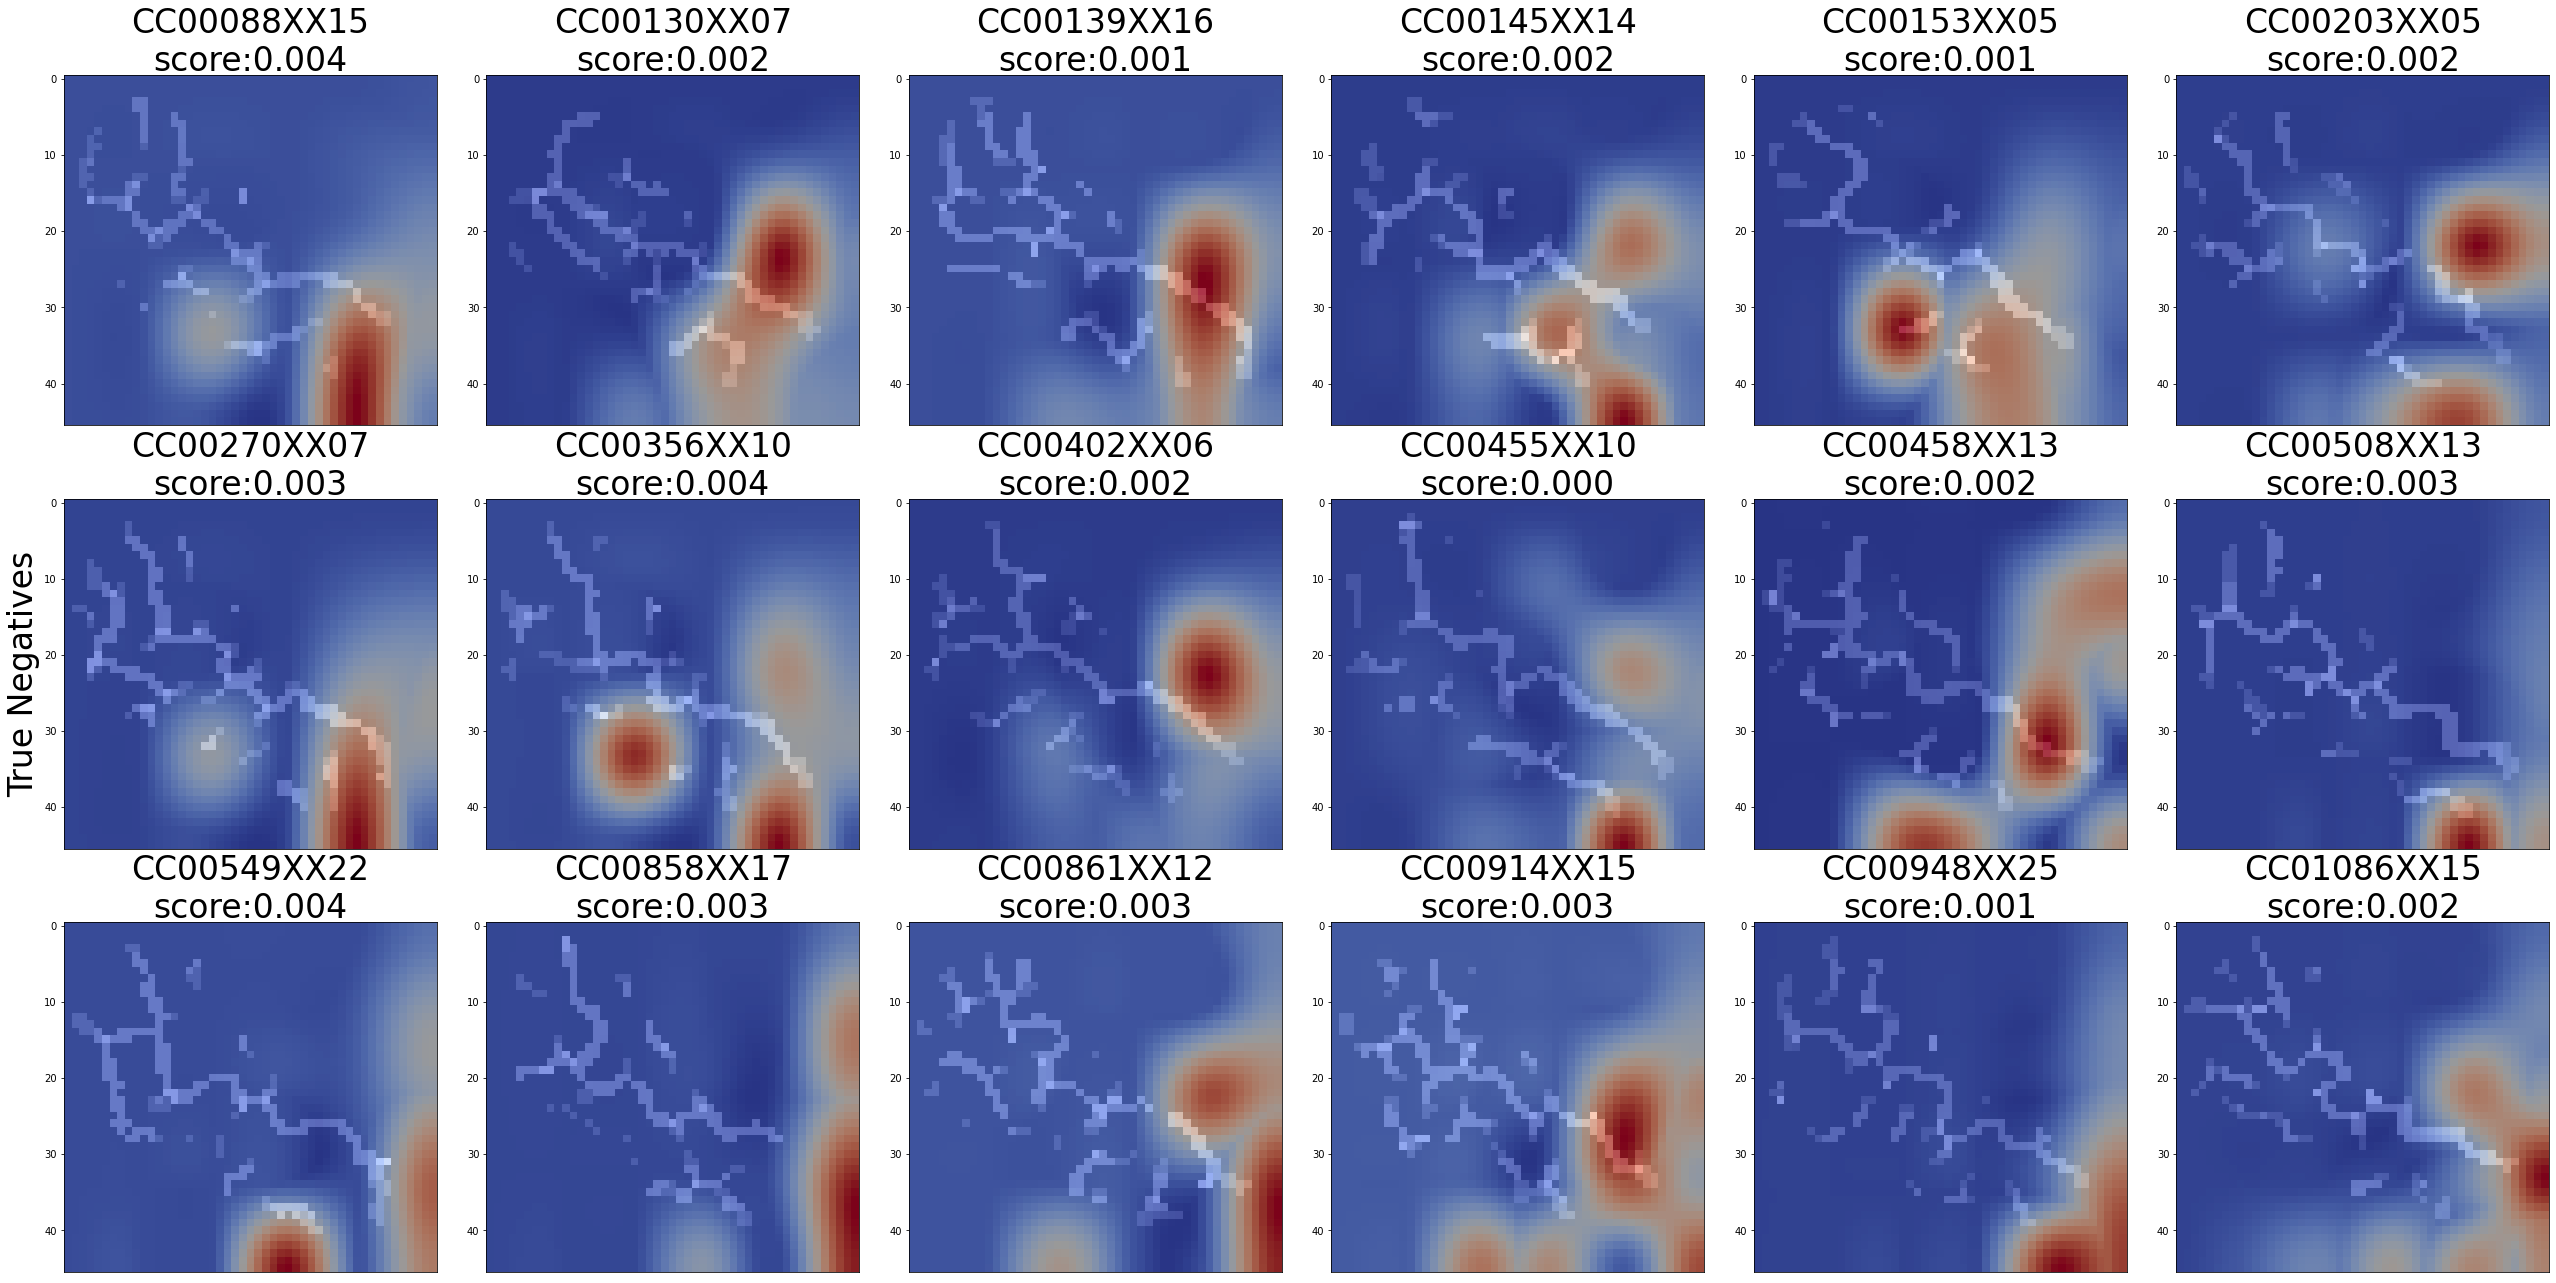

In [158]:
# do the same but without mask

###########################
plane = 0
thresh=0.98
# for x in range(11, 18, 1):
#plane = 1
#x = 14
#subset=17
c = 'TN'
x = 12
fontsize=33
###########################

cmap = mpl.cm.get_cmap("coolwarm").copy()
cmap.set_bad(color='black')

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(6*6,6*3))
gradient_subjects = dict_gradients_classes[c]
skel_subjects = dict_skels_classes[c]
for j, name in enumerate(gradient_subjects.keys()):
    gradient, skel = gradient_subjects[name], skel_subjects[name]
    #threshold = np.percentile(gradient, thresh*100)
    #gradient = gradient > threshold

    ax = axs[j//6, j%6]
    # select right plane
    im = np.max(gradient[:,:,:,0], axis=plane)
    if plane == 0:
        im_skel = skel[x,:,:,0]
    elif plane == 1:
        im_skel = skel[:,x,:,0]
    elif plane == 2:
        im_skel = skel[:,:,x,0]

    # show
    im_skel = np.rot90(im_skel, axes=(1, 0))
    im = np.rot90(im, axes=(1, 0))
    ax.imshow(im_skel, cmap='gray')
    ax.imshow(im, cmap='coolwarm', alpha=0.7)

    val_pred = df.loc[df['participant_id']==name]['val pred'].tolist()[0]
    ax.set_xlabel(name + f'\nscore:{val_pred:.3f}', fontsize=fontsize)
    ax.xaxis.set_label_position('top') # 2D individual gradient maps
    ax.set_xticks([])
    if j==6:
        ax.set_ylabel('True Negatives', fontsize=fontsize)

#plt.suptitle(f'{c} Individual samples, gradients over sagittal plane', fontsize=fontsize+4)
plt.tight_layout(pad=2)
#plt.subplots_adjust(top=0.88)
#plt.show()

plt.savefig(save_dir+f'target_0TN_1TP/without_mask/plane_{plane}/2D_gradCAM_{c}.png', facecolor='white')

In [114]:
# do the same but without mask

###########################
plane = 0
x=12
thresh=0.98
classes = ['TN', 'TP']
###########################

#cmap = mpl.cm.get_cmap("coolwarm").copy()
#cmap.set_bad(color='black')

# [(0, 22), (1, 49), (2, 46)]
plt.close()
for x in range(22):
    #fig, axs = plt.subplots(nrows=len(classes), ncols=subset, figsize=(4*subset,4*len(classes)))
    for i, c in enumerate(classes):
        gradient_subjects = dict_gradients_classes[c]
        skel_subjects = dict_skels_classes[c]
        for j, name in enumerate(gradient_subjects.keys()):
            gradient, skel = gradient_subjects[name], skel_subjects[name]
            #threshold = np.percentile(gradient, thresh*100)
            #gradient = gradient > threshold
            fig, ax = plt.subplots()
            # select right plane
            im = np.max(gradient[:,:,:,0], axis=plane)
            if plane == 0:
                im_skel = skel[x,:,:,0]
            elif plane == 1:
                im_skel = skel[:,x,:,0]
            elif plane == 2:
                im_skel = skel[:,:,x,0]
            
            # show
            im_skel = np.rot90(im_skel, axes=(1, 0))
            im_skel = im_skel.astype(bool)
            im = np.rot90(im, axes=(1, 0))
            ax.imshow(im_skel, cmap='gray')
            norms=plt.Normalize(np.min(im), np.max(im))
            ax.imshow(im, cmap='coolwarm', norm=norms, alpha=0.7)
            #ax.imshow(im, cmap='gray', alpha=0.7)

            val_pred = df.loc[df['participant_id']==name]['val pred'].tolist()[0]
            ax.set_xlabel(name + f'\nscore:{val_pred:.3f}')
            ax.xaxis.set_label_position('top') # 2D individual gradient maps
            direc = save_dir+c+'/'+name+'/'
            if not os.path.isdir(direc):
                os.mkdir(direc)
            plt.savefig(direc + f'gradient_heatmap_{x}.png', facecolor='white')
            plt.close()

# set labels on axes
#for idx, c in enumerate(classes):
#    ax = axs[idx, 0]
#    ax.set_ylabel(c)

#plt.suptitle(f'Individual samples, gradients over plane {plane}, cut = {x}')
#plt.tight_layout()
#plt.show()

# 3D using python

# 3D Anatomist: Not yet available

In [33]:
crop = aims.read('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rcrops/sub-CC01025XX11_cropped_skeleton.nii.gz')
crop_ = crop.np
print(crop.shape)
print(crop)
vol = aims.read(f'/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/gradCAM/nifti/CC01025XX11_gradient.nii.gz')
vol_ = vol.np
print(vol.shape)
print(vol)

(22, 49, 46, 1)
(12488, 1, 1, 1)


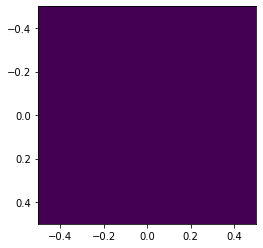

In [34]:
fig, ax = plt.subplots()
ax.imshow(crop_[14,:,:,0])
ax.imshow(vol_[14,:,:,0], alpha=0.7)
plt.show()

In [159]:
# intersect gradient with skel and save
thresh = 0.97 # keep two percent highest values of heatmap ?
names = dict_subset_subjects_classes['TN']
#target = '1'
gradients = dict_gradients_classes['TN']

## MASK OF CROP
mask = aims.read('/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/crops/2mm/S.T.s.baby/mask/Rmask_cropped.nii.gz')
mask = mask.np
mask = mask[:,:,:,0]

save_dir = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/gradCAM/nifti_TN/"
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
for subject, skel in zip(subjects, skels):
    if subject in names:
        print(subject)
        gradient = gradients[subject][:,:,:,0]
        #resize_ratio = np.array(skel.shape) / np.array(gradient.shape)
        # interpolate gradient to skel dimensions
        #gradient = zoom(np.transpose(gradient,(1,2,3,0)),
        #                resize_ratio,
        #                order=3)
        # center gradient so that almost null value is visible
        # mask gradient using skel
        threshold = np.percentile(gradient, thresh*100)
        gradient = (gradient > threshold).astype(np.int16)
        gradient = np.multiply(gradient, mask)
        vol = aims.Volume(gradient)
        vol.header()['voxel_size'] = [2,2,2,1]
        aims.write(vol, save_dir+f'{subject}_gradient.nii.gz')

CC00088XX15
CC00130XX07
CC00139XX16
CC00145XX14
CC00153XX05
CC00203XX05
CC00270XX07
CC00356XX10
CC00402XX06
CC00455XX10
CC00458XX13
CC00508XX13
CC00549XX22
CC00858XX17
CC00861XX12
CC00914XX15
CC00948XX25
CC01086XX15


In [ ]:
# convert volume to bucket
"""
python3 /neurospin/dico/jlaval/Runs/deep_folding/deep_folding/brainvisa/utils/convert_volume_to_bucket.py -s /neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/gradCAM/nifti/ -t /neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/gradCAM/buckets/
"""

# visu buckets 3D using python in pyanatomist.py